# Imports

In [1]:
# import packages
import os, sys, glob
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

sys.path.append('../')

# Preprocessing

In [2]:
# load data such that each row is a sample with one column for name and one for sequence
# add sequence 'names as a ft
def load_data(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        seqs = []
        names = []
        for i in range(0, len(lines)):
            # split line by tab
            line = lines[i].split('\t')
            names.append(line[0][1:].strip())
            seqs.append(line[1].strip())
    return pd.DataFrame({'name': names,
                         'sequence': seqs})

seqs = load_data('../data/seqs_from_ilenne.txt')
seqs.head()

context_size = 1

In [3]:
# get sequences of interest
names_of_interest = [
    "Batis_maritima_AAD26120",
    "Batis_maritima_AAD26120_point_mutation_V4N",
    "Batis_maritima_AAD26120_point_mutation_C23V",
    "Anaeromyxobacter_dehalogenans_YP_466408",
    "Brassica_oleracea_2_AAK69761",
    "Phaeosphaeria_nodorum_XP_001792029",
    "Ralstonia_solanacearum_NP_518583",
    "Vitis_vinifera_2_CAO46361",
    "Polaribacter_irgensii_ZP_01117536",
    "Burkholderia_xenovorans_YP_557005",
    "Algoriphagus_sp._ZP_01720187",
    "Neosartorya_fischeri_XP_001266691",
]

In [4]:
# check if names of interest are in the data
for name in names_of_interest:
    if name not in seqs['name'].values:
        print(f'{name} not found in data')
    else:
        print("Name:", name)
        print("Sequence:", seqs[seqs['name'] == name]['sequence'].values[0])
        print()

Name: Batis_maritima_AAD26120
Sequence: CLWWVCAYPR

Name: Batis_maritima_AAD26120_point_mutation_V4N
Sequence: CLWWVCAYPR

Name: Batis_maritima_AAD26120_point_mutation_C23V
Sequence: VLWWVCAYPR

Name: Anaeromyxobacter_dehalogenans_YP_466408
Sequence: --YW-HGFP-

Name: Brassica_oleracea_2_AAK69761
Sequence: VLWWVCAYPR

Name: Phaeosphaeria_nodorum_XP_001792029
Sequence: QRWW-CAFPN

Name: Ralstonia_solanacearum_NP_518583
Sequence: -MWW-CAVP-

Name: Vitis_vinifera_2_CAO46361
Sequence: -SWWTCAFPR

Name: Polaribacter_irgensii_ZP_01117536
Sequence: --WW-CAFP-

Name: Burkholderia_xenovorans_YP_557005
Sequence: PPWW-CAFP-

Name: Algoriphagus_sp._ZP_01720187
Sequence: --WW-CAFP-

Name: Neosartorya_fischeri_XP_001266691
Sequence: LPWF-CAFPQ



In [5]:
# check sequence lengths
np.unique(seqs['sequence'].apply(len))

array([10])

In [6]:
# get list of unique amino acids
amino_acids = [aa for aa in set(''.join(seqs['sequence']))]
amino_acids.sort()
len(amino_acids)

21

In [7]:
# SCORES / FEATURES are subject to change
# create a dictionary mapping amino acids to specific features
# first, define features we want to include

# 1. hydrophobicity (ordinal)
hydrophobic = ['A', 'C', 'I', 'L', 'M', 'F', 'V', 'W'] # 0
neutral = ['G', 'H', 'P', 'S', 'T', 'Y'] # 1
hydrophilic = ['R', 'N', 'D', 'Q', 'E', 'K', '-'] # 2

hydrophobicity = {2: hydrophobic, 
                  1: neutral, 
                  0: hydrophilic}

# 2. volume (ordinal)
very_small = ['A', 'G', 'S'] #0
small = ['N', 'D', 'C', 'P', 'T'] #1
medium = ['Q', 'E', 'H', 'V'] #2
large = ['R', 'I', 'L', 'K', 'M'] #3
very_large = ['F', 'W', 'Y'] #4
na = ['-']

volume = {1: very_small, 
          2: small, 
          3: medium, 
          4: large, 
          5: very_large,
          0: na}

# 3. chemical (arbitrary)
aliphatic = ['A', 'G', 'I', 'L', 'P', 'V']
aromatic = ['F', 'W', 'Y']
sulfur = ['C', 'M']
hydroxyl = ['S', 'T']
basic = ['R', 'H', 'K']
acidic = ['D', 'E']
amide = ['N', 'Q']
na = ['-']

# one-hot encode
chemical = {'aliphatic': aliphatic,
            'aromatic': aromatic,
            'sulfur': sulfur,
            'hydroxyl': hydroxyl,
            'basic': basic,
            'acidic': acidic,
            'amide': amide,
            'na': na}

onehot_chemical = {'aliphatic': [1, 0, 0, 0, 0, 0, 0, 0], 
            'aromatic': [0, 1, 0, 0, 0, 0, 0, 0], 
            'sulfur': [0, 0, 1, 0, 0, 0, 0, 0], 
            'hydroxyl': [0, 0, 0, 1, 0, 0, 0, 0], 
            'basic': [0, 0, 0, 0, 1, 0, 0, 0], 
            'acidic': [0, 0, 0, 0, 0, 1, 0, 0], 
            'amide': [0, 0, 0, 0, 0, 0, 1, 0],
            'na': [0, 0, 0, 0, 0, 0, 0, 1]}

# 4. charge (ordinal)
positive = ['R', 'H', 'K'] #1
negative = ['D', 'E'] #-1
uncharged = ['A', 'N', 'C', 'Q', 'G', 'I', 'L', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '-'] #0

charge = {1: positive, 
          int(-1): negative, 
          0: uncharged}

# 5. hydrogen donor/acceptor (arbitrary)
# MAYBE CHANGE TO BINARY (BOND/NOT)
bond = ['R', 'K', 'W', 'D', 'E', 'N', 'Q', 'H', 'S', 'T', 'Y']
none = ['A', 'C', 'G', 'I', 'L', 'M', 'F', 'P', 'V', '-']

hydrogen = {1: bond,
            0: none}

# 6. polarity (ordinal)
polar = ['R', 'N', 'D', 'Q', 'E', 'H', 'K', 'S', 'T', 'Y'] #1
nonpolar = ['A', 'C', 'G', 'I', 'L', 'M', 'F', 'P', 'W', 'V'] #0
na = ['-']

polarity = {'polar': polar, 
            'nonpolar': nonpolar,
            'gap': na}

onehot_polarity = {'polar': [1, 0, 0],
                    'nonpolar': [0, 1, 0],
                    'gap': [0, 0, 1]}

# allows us to map amino acids to features, creating a (num_samples, seq_length, num_features) tensor
feature_list = [hydrophobicity, volume, chemical, charge, hydrogen, polarity]

In [8]:
feature_list

[{2: ['A', 'C', 'I', 'L', 'M', 'F', 'V', 'W'],
  1: ['G', 'H', 'P', 'S', 'T', 'Y'],
  0: ['R', 'N', 'D', 'Q', 'E', 'K', '-']},
 {1: ['A', 'G', 'S'],
  2: ['N', 'D', 'C', 'P', 'T'],
  3: ['Q', 'E', 'H', 'V'],
  4: ['R', 'I', 'L', 'K', 'M'],
  5: ['F', 'W', 'Y'],
  0: ['-']},
 {'aliphatic': ['A', 'G', 'I', 'L', 'P', 'V'],
  'aromatic': ['F', 'W', 'Y'],
  'sulfur': ['C', 'M'],
  'hydroxyl': ['S', 'T'],
  'basic': ['R', 'H', 'K'],
  'acidic': ['D', 'E'],
  'amide': ['N', 'Q'],
  'na': ['-']},
 {1: ['R', 'H', 'K'],
  -1: ['D', 'E'],
  0: ['A',
   'N',
   'C',
   'Q',
   'G',
   'I',
   'L',
   'M',
   'F',
   'P',
   'S',
   'T',
   'W',
   'Y',
   'V',
   '-']},
 {1: ['R', 'K', 'W', 'D', 'E', 'N', 'Q', 'H', 'S', 'T', 'Y'],
  0: ['A', 'C', 'G', 'I', 'L', 'M', 'F', 'P', 'V', '-']},
 {'polar': ['R', 'N', 'D', 'Q', 'E', 'H', 'K', 'S', 'T', 'Y'],
  'nonpolar': ['A', 'C', 'G', 'I', 'L', 'M', 'F', 'P', 'W', 'V'],
  'gap': ['-']}]

In [9]:
# create feature dictionary that contains the properties of each amino acid
feature_dict = {}

# loop through each amino acid and create a dictionary of features
# loop through amino acids
for aa in amino_acids:
    
    # make list of features for each amino acid
    features = []
    
    # loop through each feature
    for feature in feature_list:

        # loop through each key in the feature dictionary
        for key, list in feature.items():
            if key in onehot_chemical.keys():
                if aa in list:
                    features.extend(onehot_chemical[key])
                continue
            elif key in onehot_polarity.keys():
                if aa in list:
                    features.extend(onehot_polarity[key])
                continue
            if aa in list:
                features.append(key)
    feature_dict[aa] = features

# print dictionary for feature conversion
feature_dict

{'-': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
 'A': [2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'C': [2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'D': [0, 2, 0, 0, 0, 0, 0, 1, 0, 0, -1, 1, 1, 0, 0],
 'E': [0, 3, 0, 0, 0, 0, 0, 1, 0, 0, -1, 1, 1, 0, 0],
 'F': [2, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'G': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'H': [1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
 'I': [2, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'K': [0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
 'L': [2, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'M': [2, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'N': [0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
 'P': [1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'Q': [0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
 'R': [0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
 'S': [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 'T': [1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 'V': [2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [10]:
# convert sequences to feature tensors
def seq_to_tensor(seq, feature_dict):
    # initialize tensor
    tensor = []
    
    # loop through each amino acid in the sequence
    for aa in seq:
        # get features for amino acid
        features = feature_dict[aa]
        tensor.append(features)
        
    return np.array(tensor)

In [11]:
# use pool to apply conversion function to all sequences
with mp.Pool(mp.cpu_count()) as pool:
    seq_tensors = pool.map(partial(seq_to_tensor, feature_dict=feature_dict), seqs['sequence'])

# check that all sequences are the same length
np.unique([len(seq) for seq in seq_tensors])

array([10])

In [12]:
# get names
names = seqs['name']
print(len(names))

3579


In [25]:
# get index of names of interest
soi_idx = [i for i in range(len(names)) if names[i] in names_of_interest]

In [13]:
for name in names_of_interest:
    if name not in names.values:
        print(f'{name} not found in data')

In [14]:
# convert list of tensors to numpy array
seq_tensors = np.array(seq_tensors)
seq_tensors = seq_tensors.reshape(-1, 10*15)
seq_tensors.shape

(3579, 150)

In [15]:
# scale data
seq_tensors_norm = normalize(seq_tensors)

# Dimension Reduction
* Reducing dimensions to 2 for easy visualization

In [16]:
# perform pca
pca = PCA(n_components=2)
pca_result = pca.fit_transform(seq_tensors_norm)

# perform tsne
tsne = TSNE(n_components=2, verbose=1, perplexity=40, max_iter=300)
tsne_results = tsne.fit_transform(seq_tensors_norm)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3579 samples in 0.001s...
[t-SNE] Computed neighbors for 3579 samples in 0.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3579
[t-SNE] Computed conditional probabilities for sample 2000 / 3579
[t-SNE] Computed conditional probabilities for sample 3000 / 3579
[t-SNE] Computed conditional probabilities for sample 3579 / 3579
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.685284
[t-SNE] KL divergence after 300 iterations: 0.860436


In [68]:
# get soi pca + tsne results
soi_pca = pca_result[soi_idx, :]
soi_tsne = tsne_results[soi_idx, :]

soi_pca.shape, soi_tsne.shape

((12, 2), (12, 2))

# K-Means Clustering

In [69]:
# perform kmeans clustering
K = range(2, 10)
fits = []
scores = []

for k in K:
    # fit k clusters on data
    kmeans = KMeans(n_clusters=k, random_state=0).fit(seq_tensors_norm)
    fits.append(kmeans)

    # get silhouette score
    silhouette = silhouette_score(seq_tensors_norm, kmeans.labels_, metric='euclidean')
    scores.append(silhouette)
    print(f'k={k}, score={silhouette}')
print(f"Best silhouette score: {min(scores)}, for k={scores.index(min(scores))+2}")
best_kmeans = fits[scores.index(min(scores))]

k=2, score=0.4744601583390402
k=3, score=0.49465229801960825
k=4, score=0.45740419269420646
k=5, score=0.4481808457094717
k=6, score=0.44898055627497185
k=7, score=0.4371957070290504
k=8, score=0.47765963400683775
k=9, score=0.4857992484324562
Best silhouette score: 0.4371957070290504, for k=7


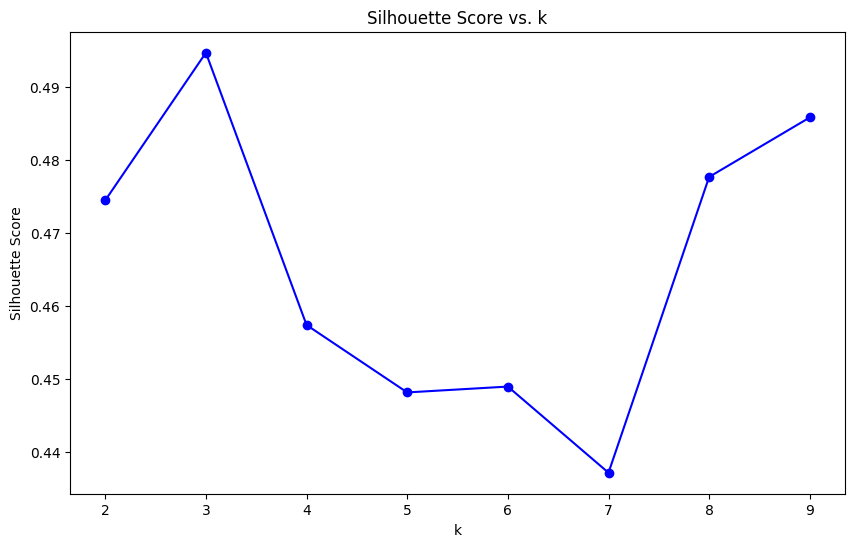

In [70]:
# plot scores vs. k
plt.figure(figsize=(10, 6))
plt.plot(K, scores, 'bo-')
for xy in zip(K, B):                                       # <--
    plt.annotate(f'{score:.2f}', textcoords='data') 
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.show()

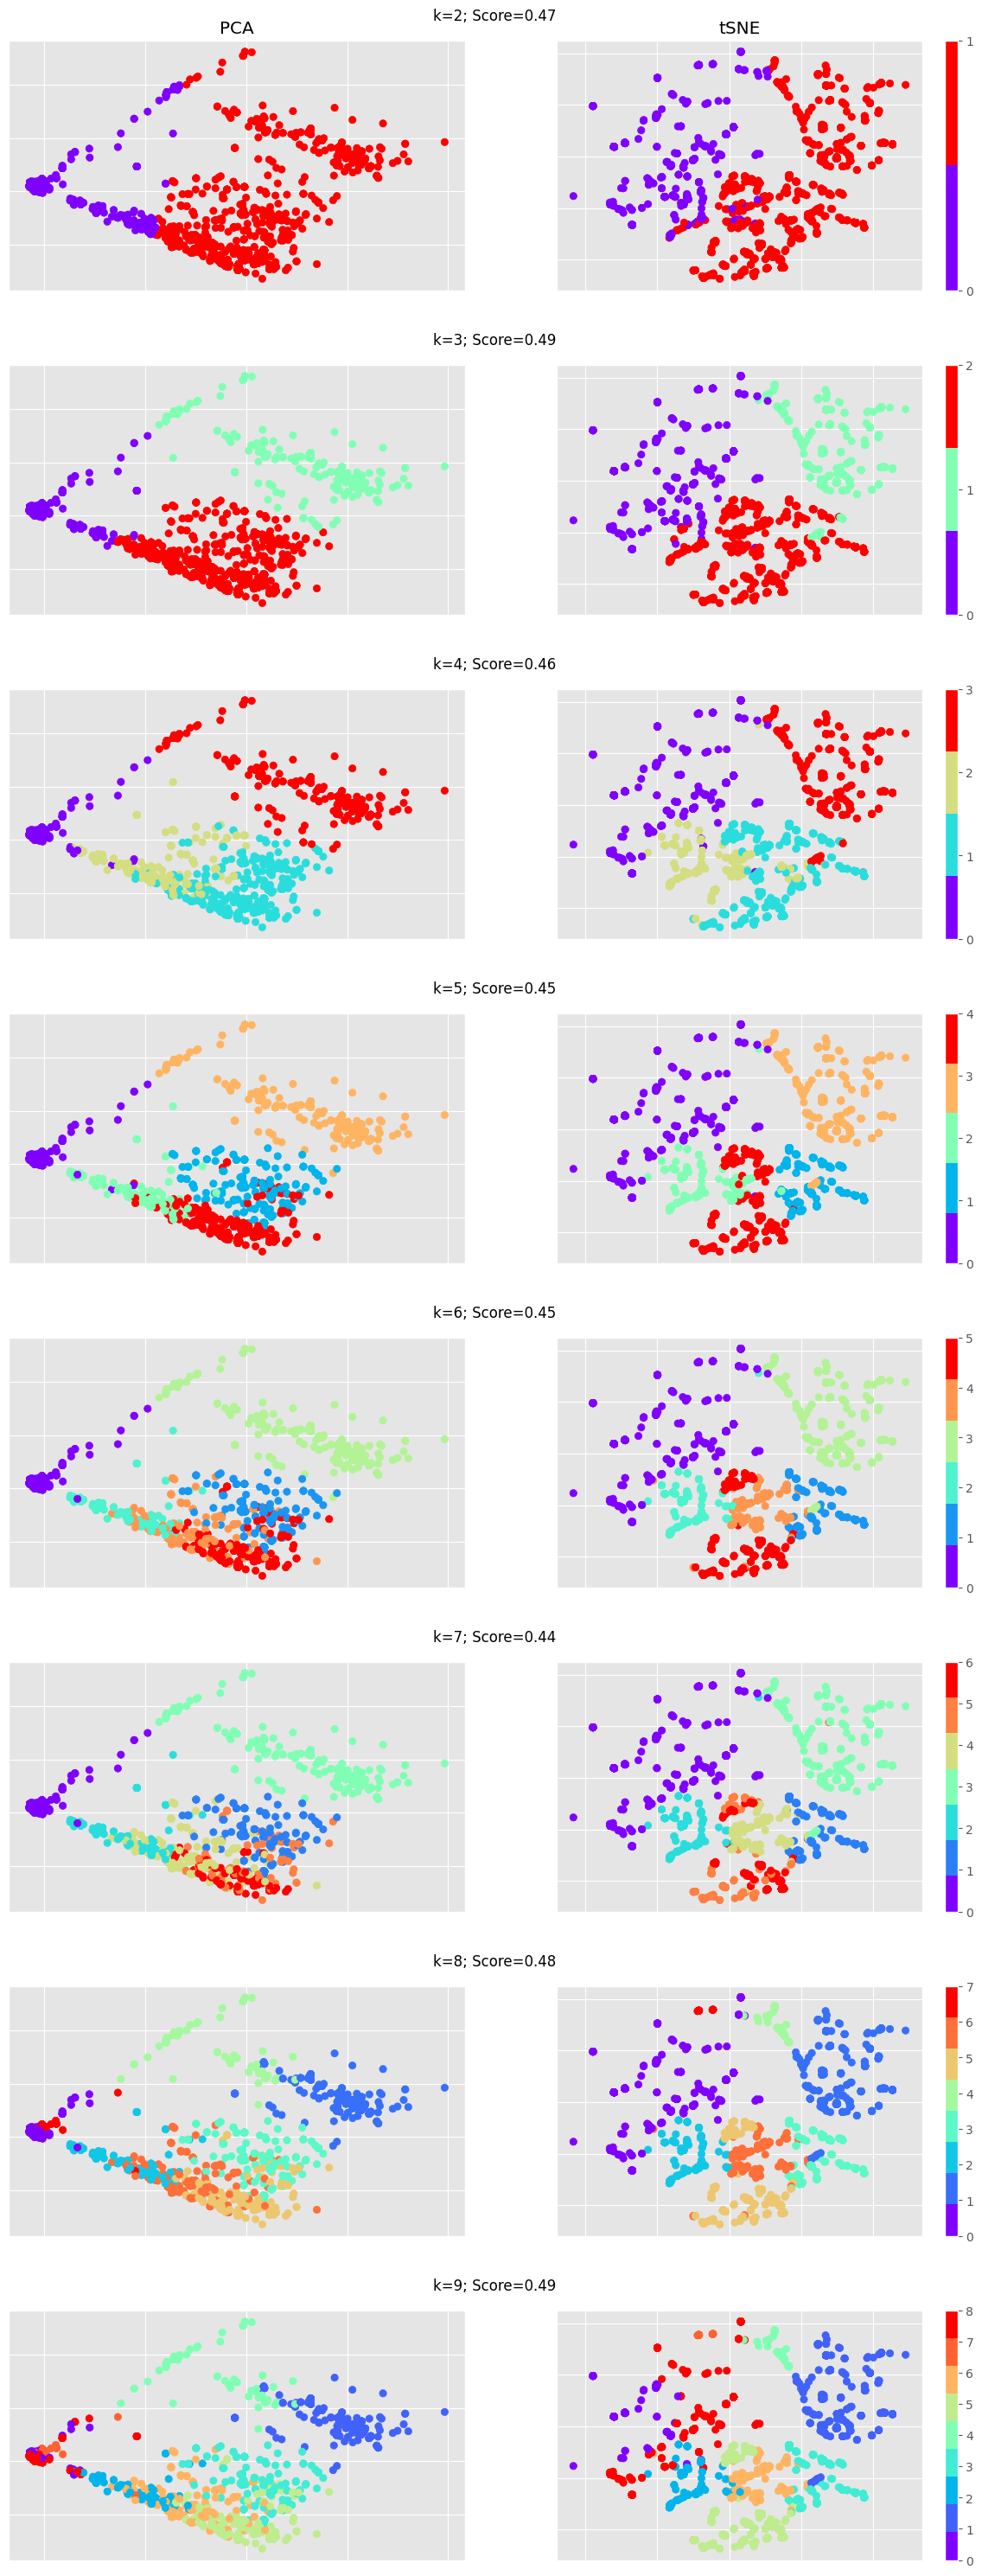

In [71]:
# plot clusters with tsne
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15, 30))

    # create subplots
    subfigs = fig.subfigures(len(fits), 1)

    for row, subfig in enumerate(subfigs):
        cmap = plt.get_cmap('rainbow', len(np.unique(fits[row].labels_)))

        # get classes
        classes = fits[row].labels_
        score = scores[row]

        subfig.suptitle(f'k={row+2}; Score={score:.2f}')

        ax = subfig.subplots(nrows=1, ncols=2)
        # plot pca
        ax[0].scatter(pca_result[:,0], pca_result[:,1], c=classes, cmap=cmap)


        # plot tsne
        subfig.colorbar(ax[1].scatter(tsne_results[:,0], tsne_results[:,1], c=classes, cmap=cmap),
                        ticks = range(0, row+2),  
                        format = '%1i')
        if row == 0:
            ax[0].set_title('PCA')
            ax[1].set_title('tSNE')

        ax[0].tick_params(left = False, right = False , labelleft = False , 
                          labelbottom = False, bottom = False)
        ax[1].tick_params(left = False, right = False , labelleft = False , 
                          labelbottom = False, bottom = False) 
    plt.show()


# Hierarchical Clustering
* Using standard [agglomerative clustering](../notes/ClusteringMethods.md) methods.

In [72]:
# perform hierarchical clustering
# number of clusters to  try
N = range(2, 10)
agg_fits = []
agg_scores = []
for n in N:
    agg_fit = AgglomerativeClustering(n_clusters=n, linkage='ward').fit_predict(seq_tensors_norm)
    agg_fits.append(agg_fit)

    agg_score = silhouette_score(seq_tensors_norm, agg_fit)
    agg_scores.append(agg_score)
    print(f'Clusters = {n}, Score = {agg_score}')
print(f"Best silhouette score: {min(agg_scores)}, for k={agg_scores.index(min(agg_scores))+2}")
best_agg = agg_fits[agg_scores.index(min(agg_scores))]

Clusters = 2, Score = 0.44902102741409694
Clusters = 3, Score = 0.47936838701436996
Clusters = 4, Score = 0.4758399367837682
Clusters = 5, Score = 0.4589093084608255
Clusters = 6, Score = 0.45872207977237744
Clusters = 7, Score = 0.45824102633272484
Clusters = 8, Score = 0.4635268382462687
Clusters = 9, Score = 0.46089250965092876
Best silhouette score: 0.44902102741409694, for k=2


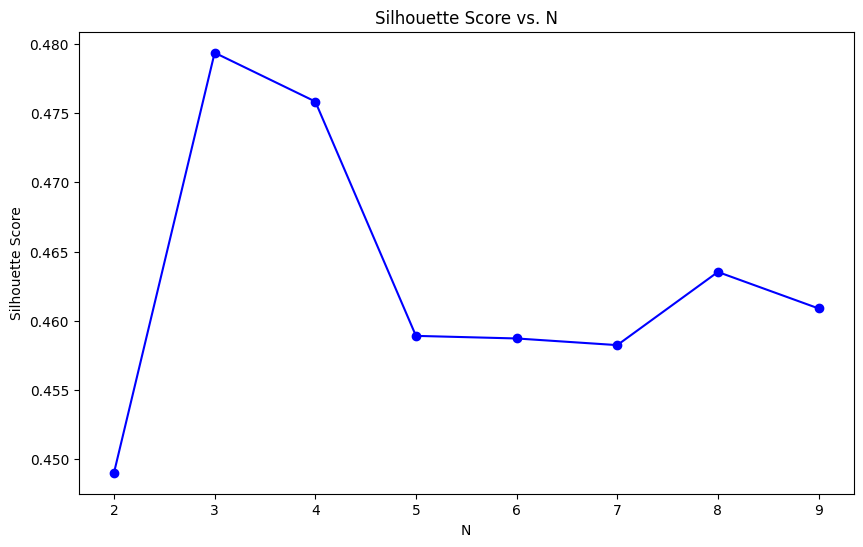

In [73]:
# plot scores vs. k
plt.figure(figsize=(10, 6))
plt.plot(N, agg_scores, 'bo-')
plt.xlabel('N')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. N')
plt.show()

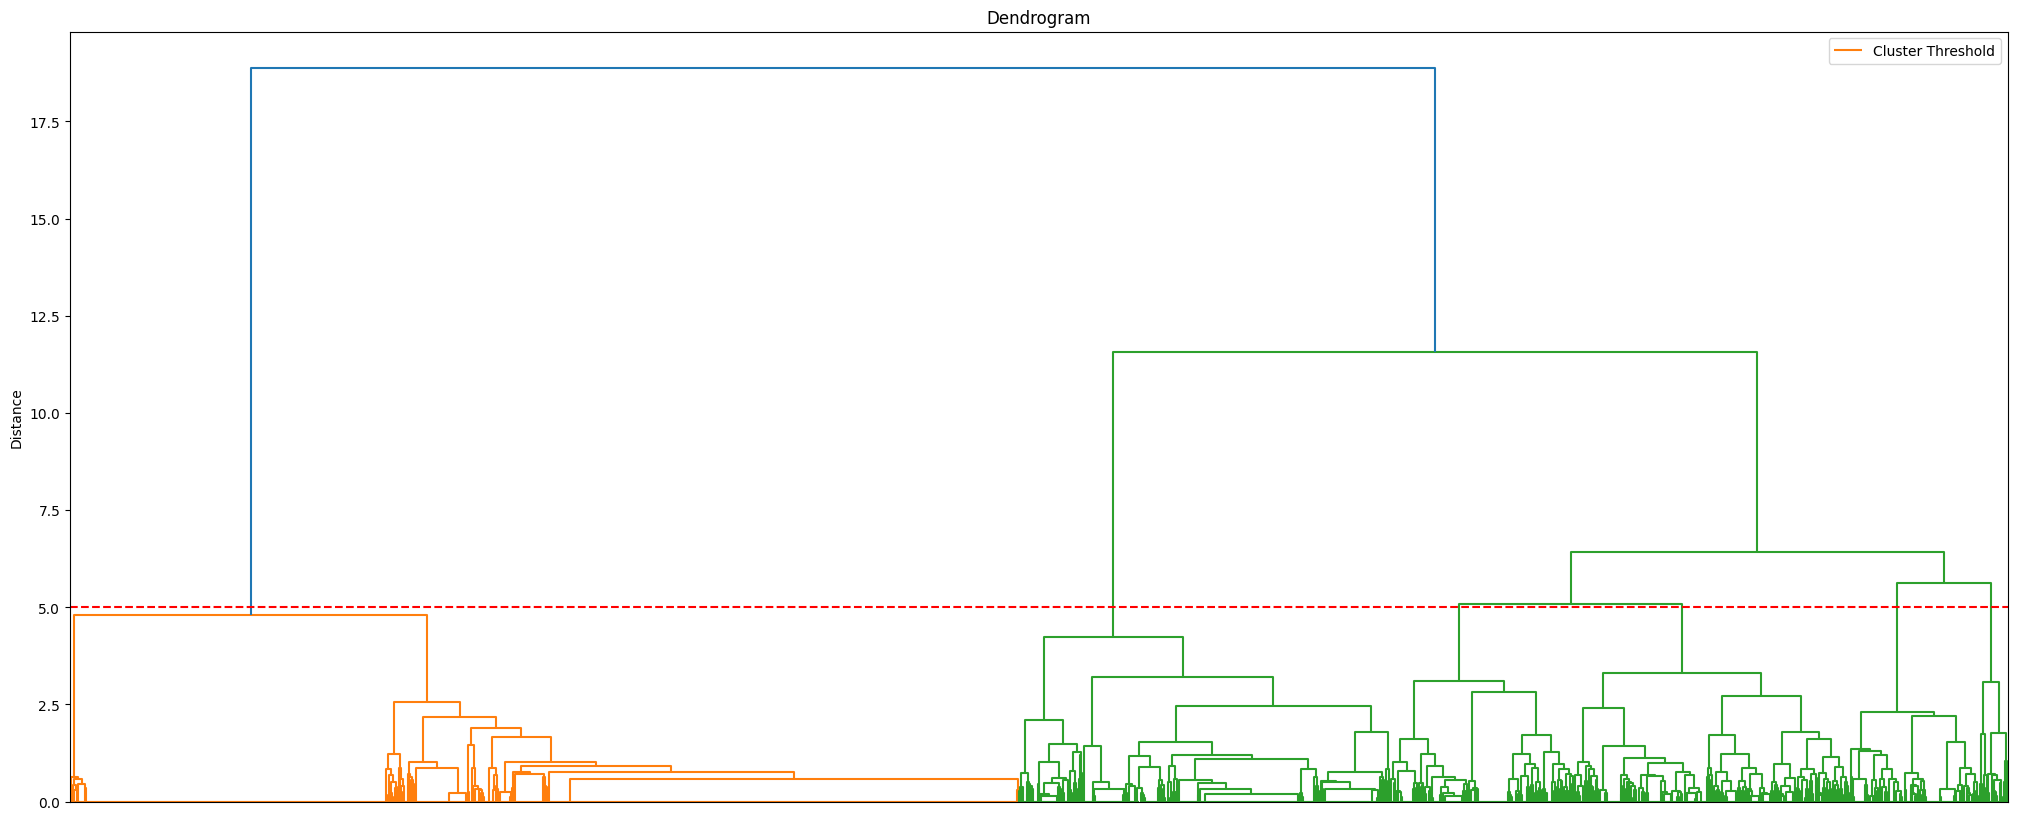

In [74]:
# plot dendrogram for best clustering
Z = linkage(seq_tensors_norm, 'ward')
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=5.0, color='r', linestyle='--')
plt.gca().axes.get_xaxis().set_visible(False)
plt.legend(['Cluster Threshold'])
plt.show()

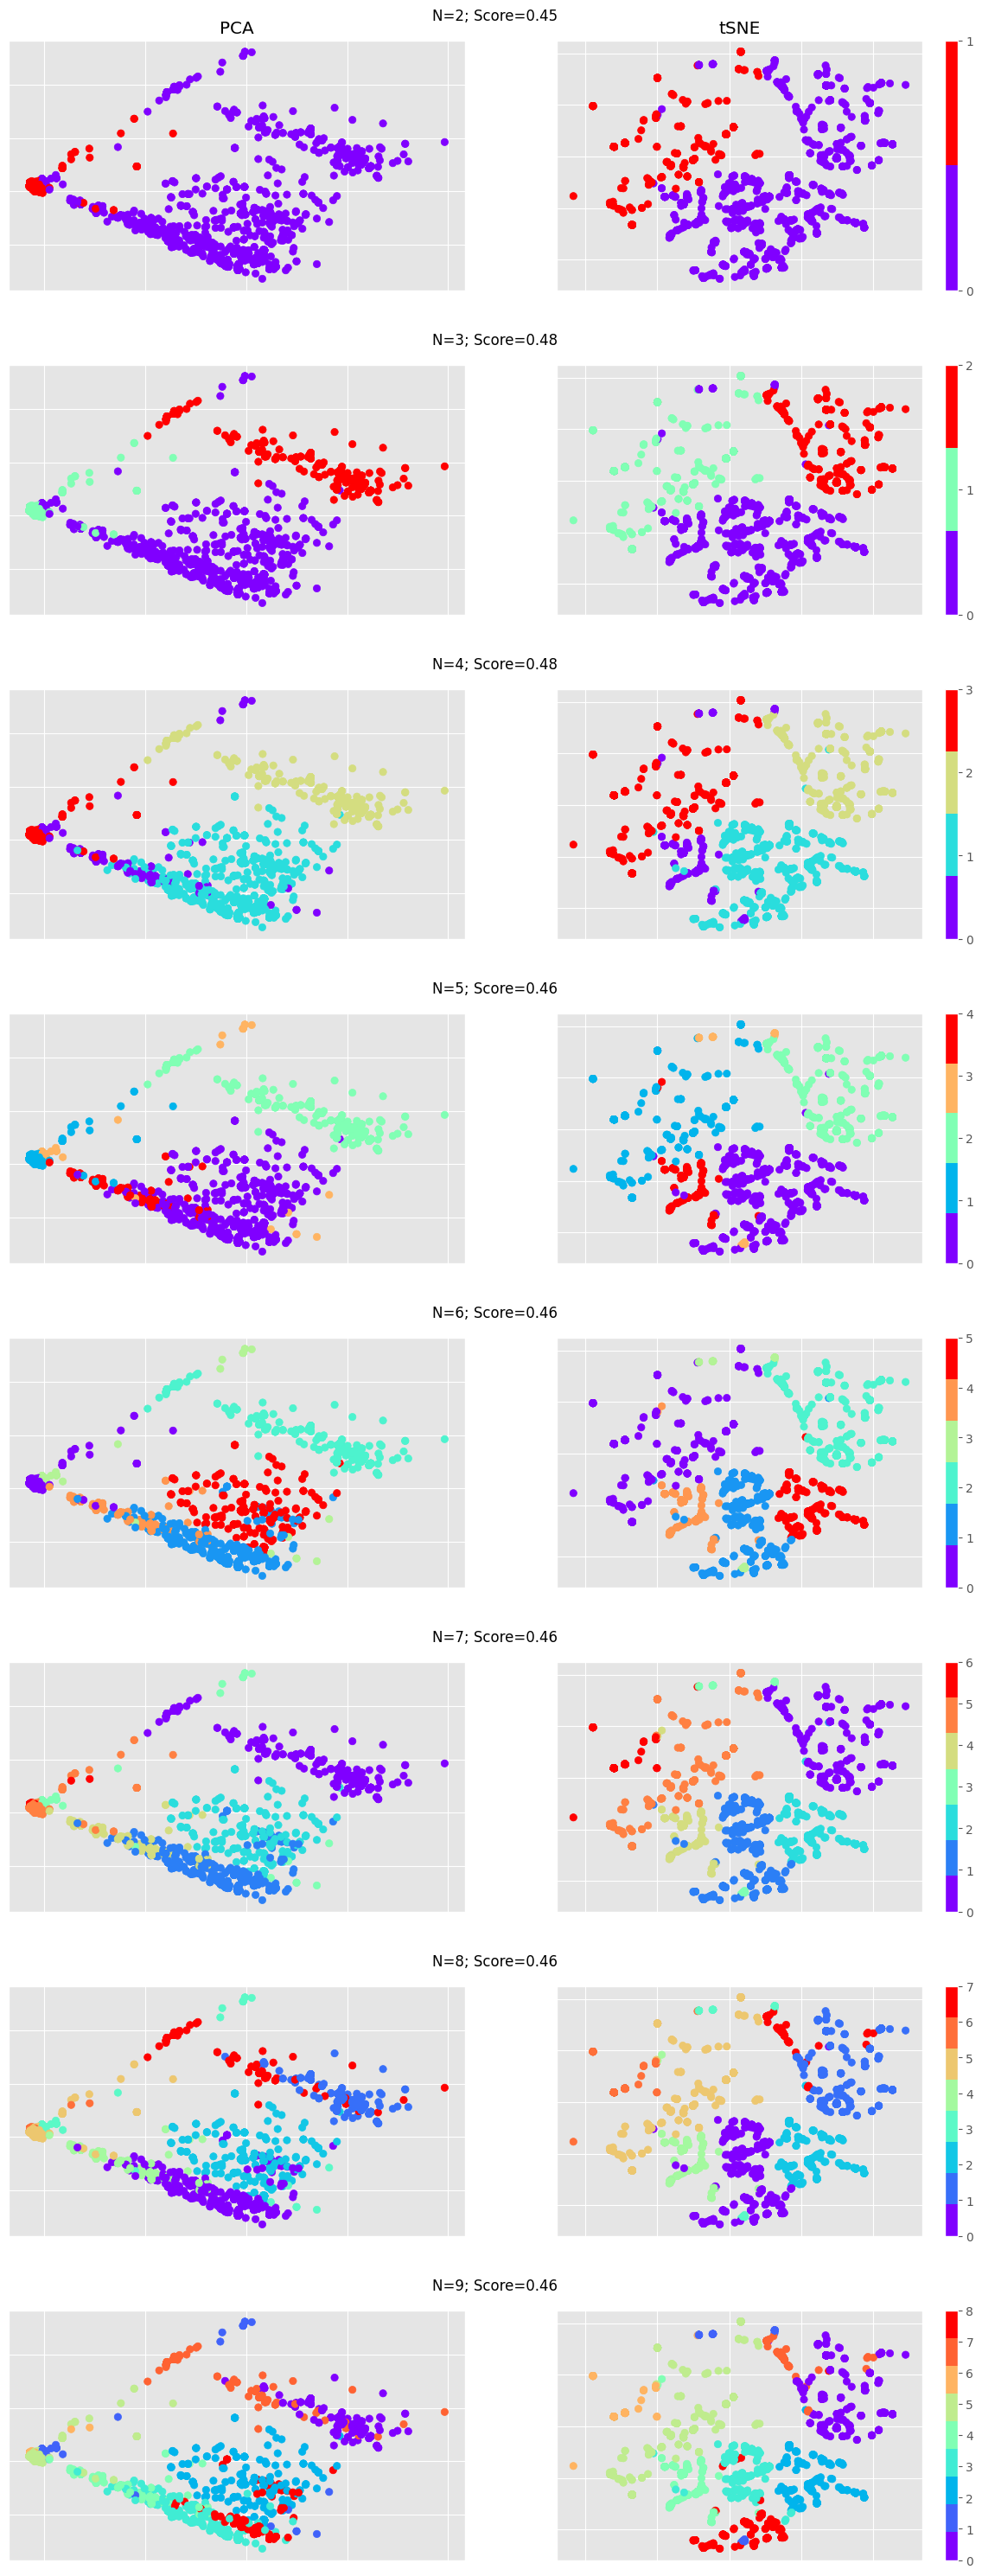

In [75]:
# plot hc clusters with tsne / pca
# plot clusters with tsne
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15, 30))

    # create subplots
    subfigs = fig.subfigures(len(fits), 1)

    for row, subfig in enumerate(subfigs):
        cmap = plt.get_cmap('rainbow', len(np.unique(fits[row].labels_)))

        # get classes
        classes = agg_fits[row]
        score = agg_scores[row]

        subfig.suptitle(f'N={row+2}; Score={score:.2f}')

        ax = subfig.subplots(nrows=1, ncols=2)
        # plot pca
        ax[0].scatter(pca_result[:,0], pca_result[:,1], c=classes, cmap=cmap)

        # plot tsne
        subfig.colorbar(ax[1].scatter(tsne_results[:,0], tsne_results[:,1], c=classes, cmap=cmap),
                        ticks = range(0, row+2),  
                        format = '%1i')
        if row == 0:
            ax[0].set_title('PCA')
            ax[1].set_title('tSNE')

        ax[0].tick_params(left = False, right = False , labelleft = False , 
                          labelbottom = False, bottom = False)
        ax[1].tick_params(left = False, right = False , labelleft = False , 
                          labelbottom = False, bottom = False)

    plt.show()

# Plot K-Means and Hierarchical Clusters Side-by-Side

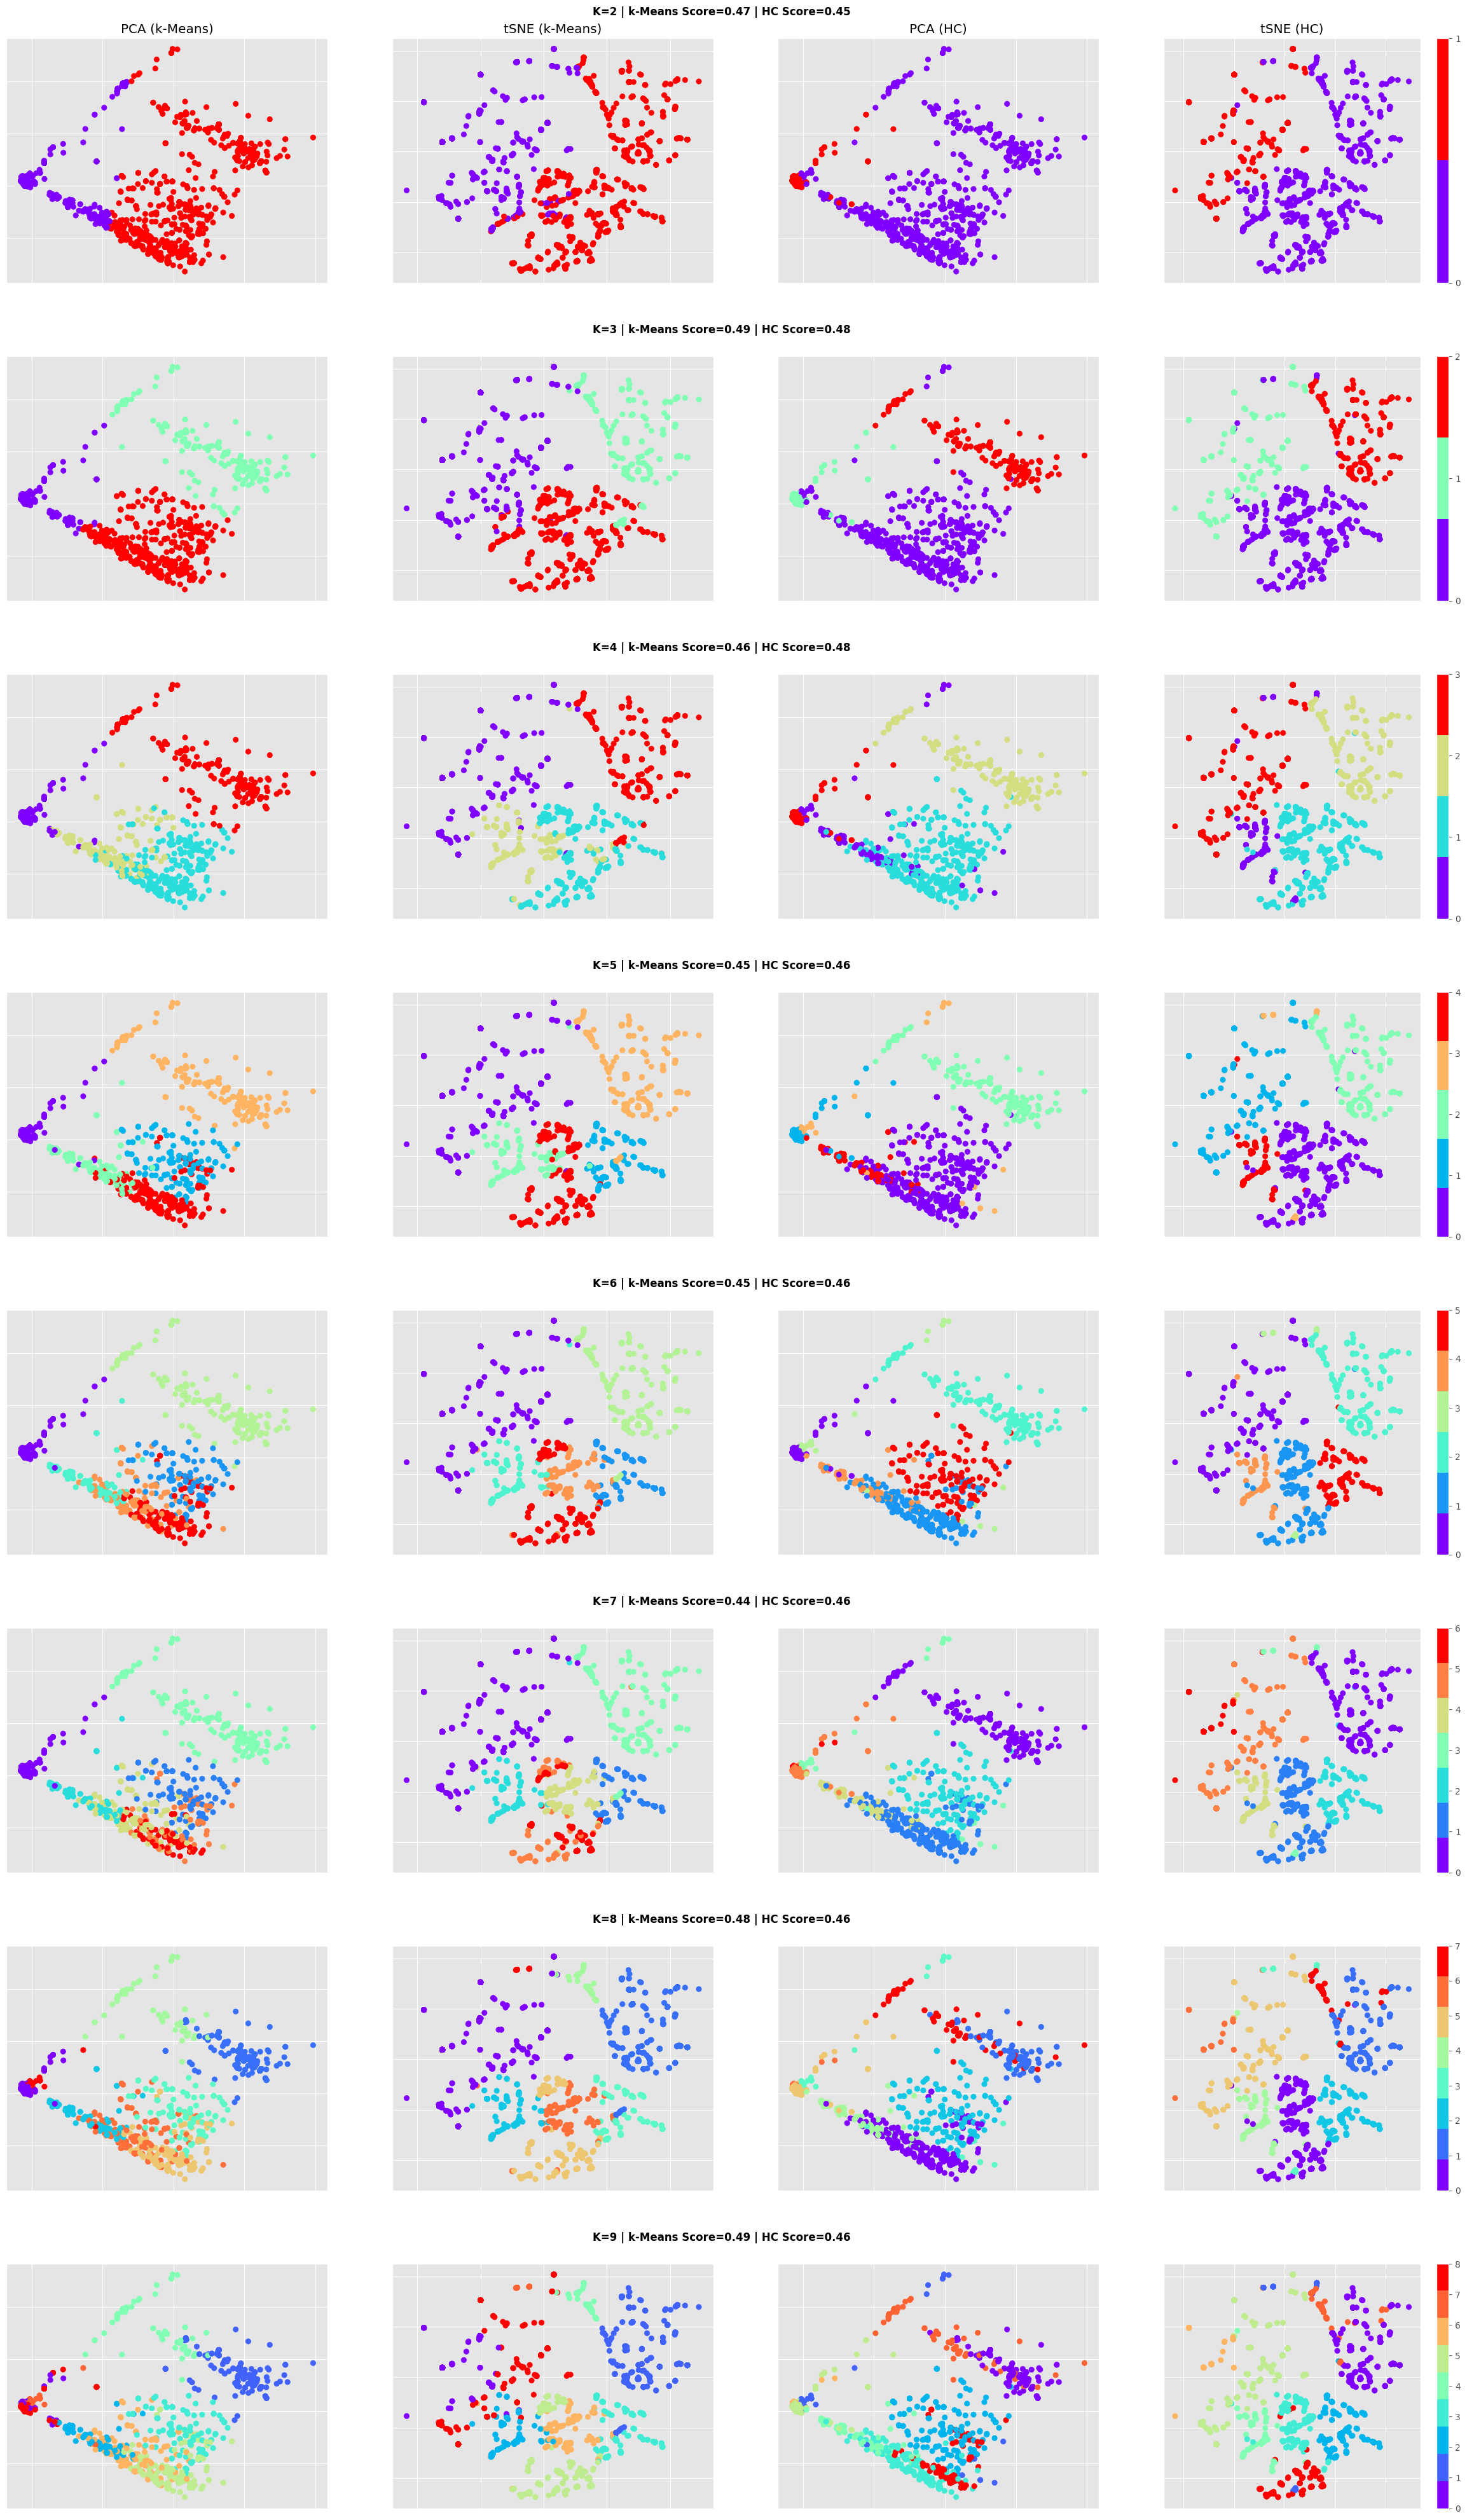

In [76]:
# plot hc and kmeans clusters side by side
# plot hc clusters with tsne / pca
# plot clusters with tsne
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(30, 40))

    # create subplots
    subfigs = fig.subfigures(len(fits), 1)

    for row, subfig in enumerate(subfigs):
        cmap = plt.get_cmap('rainbow', len(np.unique(fits[row].labels_)))
        # get kmeans classes
        kmeans_classes = fits[row].labels_
        kmeans_score = scores[row]

        # get hc classes
        agg_classes = agg_fits[row]
        agg_score = agg_scores[row]

        subfig.suptitle(f'K={row+2} | k-Means Score={kmeans_score:.2f} | HC Score={agg_score:.2f}', weight='bold')

        ax = subfig.subplots(nrows=1, ncols=4)

        # plot pca (all points)
        ax[0].scatter(pca_result[:,0], pca_result[:,1], c=kmeans_classes, cmap=cmap)
        ax[2].scatter(pca_result[:,0], pca_result[:,1], c=agg_classes, cmap=cmap)

        # plot tsne
        ax[1].scatter(tsne_results[:,0], tsne_results[:,1], c=kmeans_classes, cmap=cmap)
        
        subfig.colorbar(ax[3].scatter(tsne_results[:,0], tsne_results[:,1], c=agg_classes, cmap=cmap),
                        ticks = range(0, row+2),  
                        format = '%1i')

        if row == 0:
            ax[0].set_title('PCA (k-Means)')
            ax[1].set_title('tSNE (k-Means)')
            ax[2].set_title('PCA (HC)')
            ax[3].set_title('tSNE (HC)')

        for i in range(4):
            ax[i].tick_params(left = False, right = False , labelleft = False , 
                            labelbottom = False, bottom = False)
        
    plt.show()


# Highlight Sequences of Interest in Clusters

In [77]:
# define random jitter function to separate identical points
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

[0 1]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3 4]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4]
[0 1 2 3 4 5 6]
[0 1 2 3 4]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 6]
[0 1 2 3 4 5 6 7 8]
[1 2 3 4 6 8]


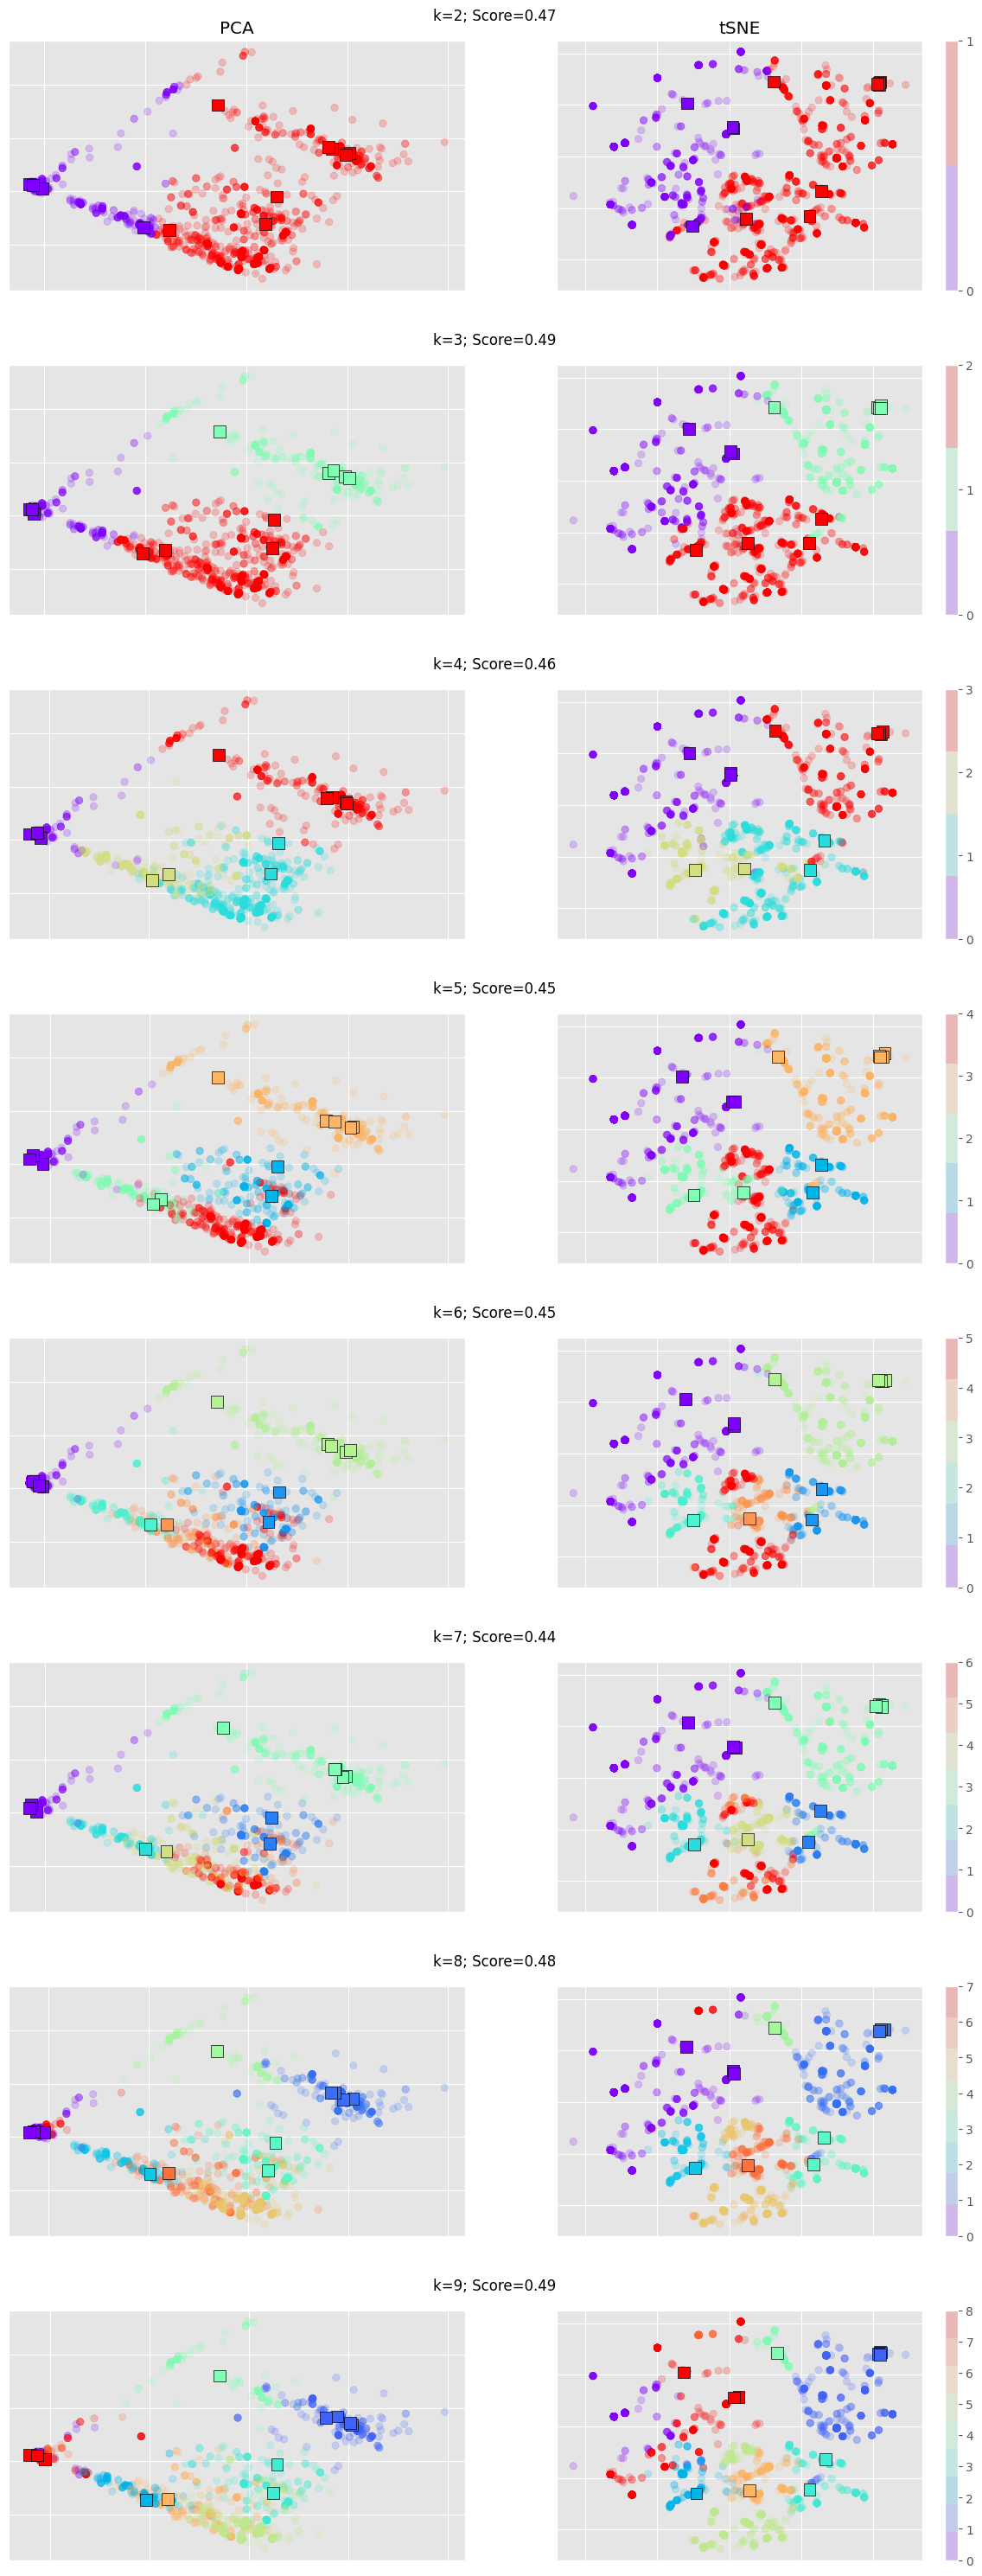

In [121]:
# plot clusters with tsne
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(15, 30))

    # create subplots
    subfigs = fig.subfigures(len(fits), 1)

    for row, subfig in enumerate(subfigs):
        cmap = plt.get_cmap('rainbow', len(np.unique(fits[row].labels_)))

        # get classes
        classes = fits[row].labels_
        clist = {i: cmap(i) for i in range(len(np.unique(classes)))}
        score = scores[row]

        # get labels and index for each sequence of interest
        soi_classes = [classes[i] for i in soi_idx]

        subfig.suptitle(f'k={row+2}; Score={score:.2f}')

        ax = subfig.subplots(nrows=1, ncols=2)

        # plot pca (all clusters)
        ax[0].scatter(pca_result[:,0], pca_result[:,1], c=classes, cmap=cmap, alpha=0.2)
        ax[0].scatter(rand_jitter(soi_pca[:,0]),rand_jitter(soi_pca[:,1]), marker=",", c=[clist[i] for i in soi_classes], edgecolor='black', s=100)

        # plot tsne
        subfig.colorbar(ax[1].scatter(tsne_results[:,0], tsne_results[:,1], c=classes, cmap=cmap, alpha=0.2),
                        ticks = range(0, row+2),  
                        format = '%1i')

        ax[1].scatter(rand_jitter(soi_tsne[:,0]),rand_jitter(soi_tsne[:,1]), marker=",", c=[clist[i] for i in soi_classes], edgecolor='black', s=100)

        if row == 0:
            ax[0].set_title('PCA')
            ax[1].set_title('tSNE')

        ax[0].tick_params(left = False, right = False , labelleft = False , 
                          labelbottom = False, bottom = False)
        ax[1].tick_params(left = False, right = False , labelleft = False , 
                          labelbottom = False, bottom = False) 
    plt.show()



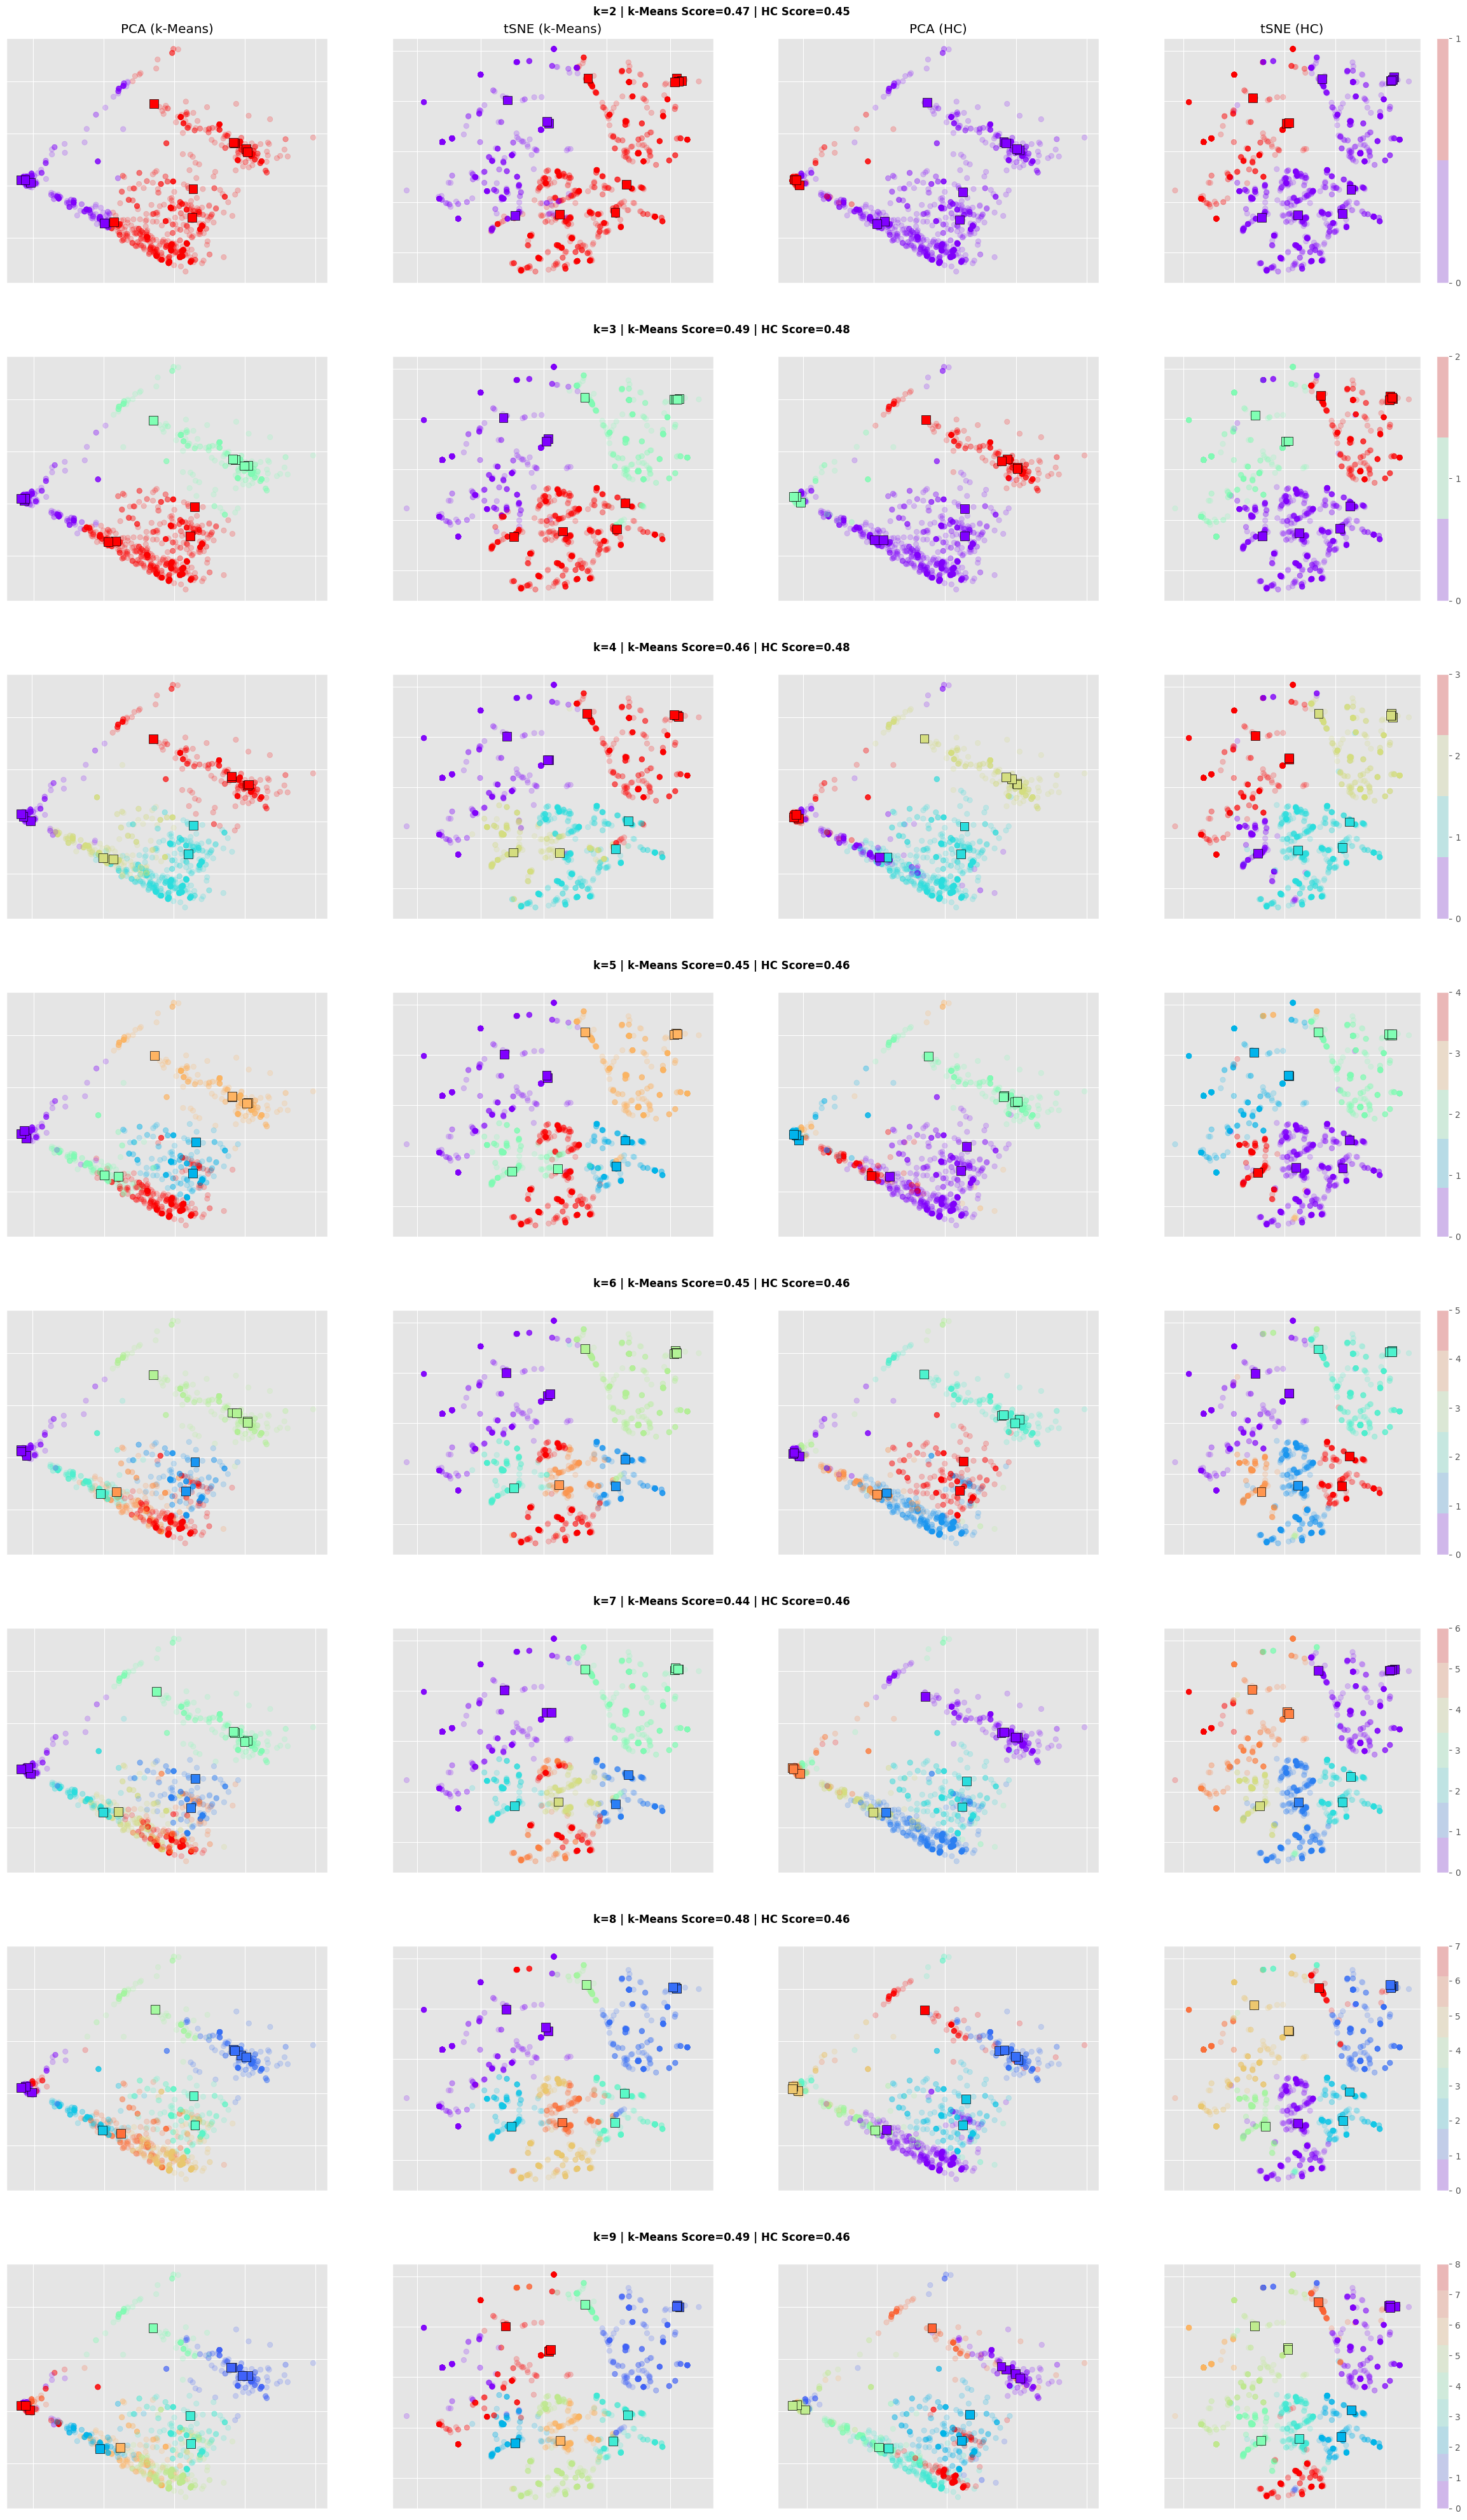

In [123]:
# and in all clusters
# plot hc and kmeans clusters side by side
# plot hc clusters with tsne / pca
# plot clusters with tsne
with plt.style.context('ggplot'):
    fig = plt.figure(figsize=(30, 40))

    # create subplots
    subfigs = fig.subfigures(len(fits), 1)

    for row, subfig in enumerate(subfigs):
        cmap = plt.get_cmap('rainbow', len(np.unique(fits[row].labels_)))
        # get kmeans classes
        kmeans_classes = fits[row].labels_
        kmeans_clist = {i: cmap(i) for i in range(len(np.unique(kmeans_classes)))}
        kmeans_score = scores[row]

        # get hc classes
        agg_classes = agg_fits[row]
        agg_clist = {i: cmap(i) for i in range(len(np.unique(agg_classes)))}
        agg_score = agg_scores[row]

        soi_kmeans_classes = [kmeans_classes[i] for i in soi_idx]
        soi_agg_classes = [agg_classes[i] for i in soi_idx]

        subfig.suptitle(f'k={row+2} | k-Means Score={kmeans_score:.2f} | HC Score={agg_score:.2f}', weight='bold')

        ax = subfig.subplots(nrows=1, ncols=4)

        # plot pca (all points)
        ax[0].scatter(pca_result[:,0], pca_result[:,1], c=kmeans_classes, cmap=cmap, alpha = 0.2)
        ax[0].scatter(rand_jitter(soi_pca[:,0]),rand_jitter(soi_pca[:,1]), marker=",", c=[kmeans_clist[i] for i in soi_kmeans_classes], edgecolor='black', s=100)

        ax[2].scatter(pca_result[:,0], pca_result[:,1], c=agg_classes, cmap=cmap, alpha = 0.2)
        ax[2].scatter(rand_jitter(soi_pca[:,0]),rand_jitter(soi_pca[:,1]), marker=",", c=[agg_clist[i] for i in soi_agg_classes], edgecolor='black', s=100)

        # plot tsne
        ax[1].scatter(tsne_results[:,0], tsne_results[:,1], c=kmeans_classes, cmap=cmap, alpha = 0.2)
        ax[1].scatter(rand_jitter(soi_tsne[:,0]),rand_jitter(soi_tsne[:,1]), marker=",", c=[kmeans_clist[i] for i in soi_kmeans_classes], edgecolor='black', s=100)
        subfig.colorbar(ax[3].scatter(tsne_results[:,0], tsne_results[:,1], c=agg_classes, cmap=cmap, alpha = 0.2),
                        ticks = range(0, row+2),  
                        format = '%1i')
        ax[3].scatter(rand_jitter(soi_tsne[:,0]),rand_jitter(soi_tsne[:,1]), marker=",", c=[agg_clist[i] for i in soi_agg_classes], edgecolor='black', s=100)

        if row == 0:
            ax[0].set_title('PCA (k-Means)')
            ax[1].set_title('tSNE (k-Means)')
            ax[2].set_title('PCA (HC)')
            ax[3].set_title('tSNE (HC)')

        for i in range(4):
            ax[i].tick_params(left = False, right = False , labelleft = False , 
                            labelbottom = False, bottom = False)
        
    plt.show()


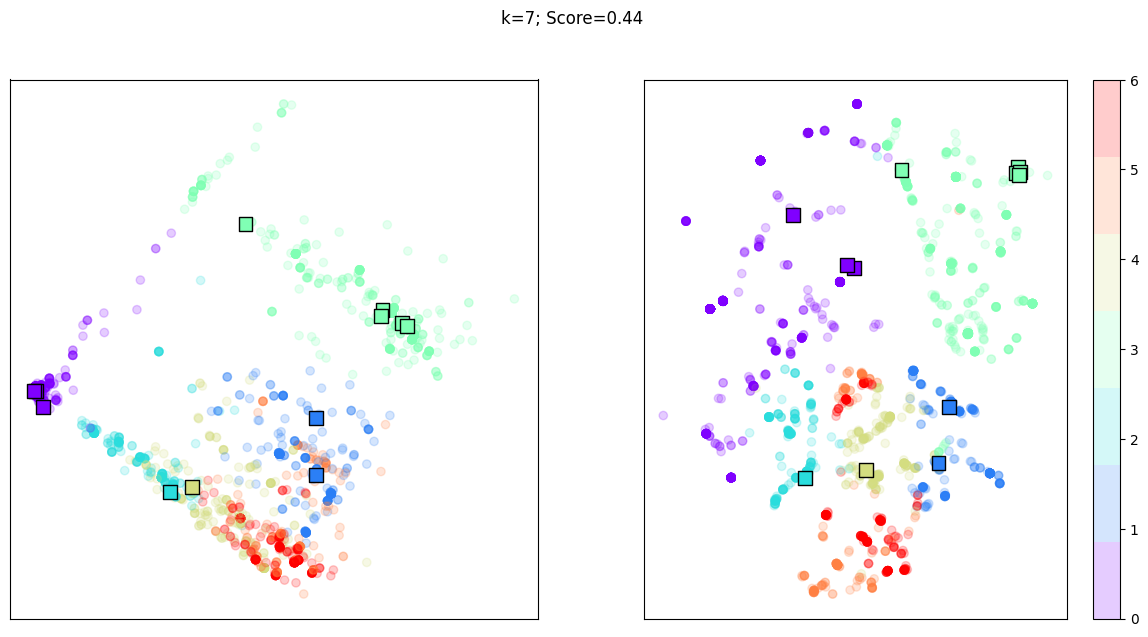

In [119]:
# plot at k=7 only
# plot clusters with tsne
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

row = 7 - 2 # subtract 2 to get proper index

cmap = plt.get_cmap('rainbow', row+2)


# get classes
classes = fits[row].labels_

# map classes to colors
clist = {i:cmap(i) for i in range(row+2)} 

score = scores[row]


# get labels and index for each sequence of interest
soi_classes = classes[soi_idx]

# plot pca (all clusters)
ax[0].scatter(pca_result[:,0], pca_result[:,1], c=classes, cmap=cmap, alpha=0.2)
ax[0].scatter(rand_jitter(soi_pca[:,0]),rand_jitter(soi_pca[:,1]), marker=",", c=[clist[i] for i in soi_classes], edgecolor='black', s=100)

# plot tsne
plt.colorbar(ax[1].scatter(tsne_results[:,0], tsne_results[:,1], c=classes, cmap=cmap, alpha=0.2),
                ticks = range(0, row+2),  
                format = '%1i')

ax[1].scatter(rand_jitter(soi_tsne[:,0]),rand_jitter(soi_tsne[:,1]), marker=",", c=[clist[i] for i in soi_classes], edgecolor='black', s=100)

if row == 0:
    ax[0].set_title('PCA')
    ax[1].set_title('tSNE')

ax[0].tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False)
ax[1].tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False)

plt.suptitle(f'k={row+2}; Score={score:.2f}')
plt.show()


In [111]:
np.array(range(row))

array([0, 1, 2, 3, 4])

In [113]:
clist

{0: (0.5, 0.0, 1.0, 1.0),
 1: (0.16666666666666669, 0.49999999999999994, 0.9659258262890683, 1.0),
 2: (0.16666666666666663, 0.8660254037844386, 0.8660254037844387, 1.0),
 3: (0.5, 1.0, 0.7071067811865476, 1.0),
 4: (0.8333333333333333, 0.8660254037844387, 0.5000000000000001, 1.0),
 5: (1.0, 0.5000000000000003, 0.25881904510252096, 1.0),
 6: (1.0, 1.2246467991473532e-16, 6.123233995736766e-17, 1.0)}

# Make Dataframe with Class Labels and Export

In [39]:
kmeans_labels = best_kmeans.labels_
agg_labels = best_agg

# make df of names, sequences, and labels
cluster_df = pd.DataFrame({'name': names, 
                           'sequence': seqs['sequence'], 
                           'kmeans_label': kmeans_labels,
                           'agg_label': agg_labels})

In [40]:
cluster_df.head()

name    sequence  kmeans_label  agg_label
0  3LCC_1|Chain  VLWWVCAYPR             3          0
1  KAH1089974.1  IQWWTCAFPR             3          0
2  KAA3454986.1  IQWWTCAFP-             5          0
3    TYJ19273.1  IQWWTCAF--             5          0
4  KAB2066690.1  IQWWTCAFPR             3          0

In [43]:
# look at where sequences of interest are clustered
for name in names_of_interest:
    print("Name:", name, "| Sequence:", cluster_df[cluster_df['name'] == name]["sequence"].values[0])
    print("K-Means Group:", cluster_df[cluster_df['name'] == name]["kmeans_label"].values[0], "")
    print()

Name: Batis_maritima_AAD26120 | Sequence: CLWWVCAYPR
K-Means Group: 3 

Name: Batis_maritima_AAD26120_point_mutation_V4N | Sequence: CLWWVCAYPR
K-Means Group: 3 

Name: Batis_maritima_AAD26120_point_mutation_C23V | Sequence: VLWWVCAYPR
K-Means Group: 3 

Name: Anaeromyxobacter_dehalogenans_YP_466408 | Sequence: --YW-HGFP-
K-Means Group: 0 

Name: Brassica_oleracea_2_AAK69761 | Sequence: VLWWVCAYPR
K-Means Group: 3 

Name: Phaeosphaeria_nodorum_XP_001792029 | Sequence: QRWW-CAFPN
K-Means Group: 1 

Name: Ralstonia_solanacearum_NP_518583 | Sequence: -MWW-CAVP-
K-Means Group: 2 

Name: Vitis_vinifera_2_CAO46361 | Sequence: -SWWTCAFPR
K-Means Group: 3 

Name: Polaribacter_irgensii_ZP_01117536 | Sequence: --WW-CAFP-
K-Means Group: 0 

Name: Burkholderia_xenovorans_YP_557005 | Sequence: PPWW-CAFP-
K-Means Group: 4 

Name: Algoriphagus_sp._ZP_01720187 | Sequence: --WW-CAFP-
K-Means Group: 0 

Name: Neosartorya_fischeri_XP_001266691 | Sequence: LPWF-CAFPQ
K-Means Group: 1 



In [ ]:
cluster_df.to_csv('../data/clustered_sequences.csv', index=False)